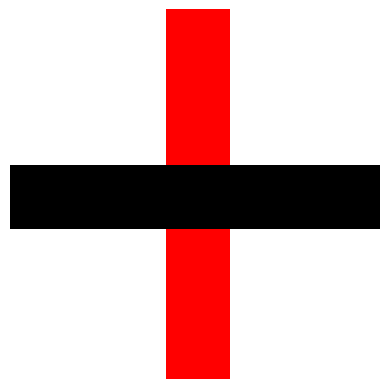

<ipython-input-2-b9dbc7a70a37>:70: RuntimeWarning: overflow encountered in ubyte_scalars
  lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
<ipython-input-2-b9dbc7a70a37>:74: RuntimeWarning: overflow encountered in ubyte_scalars
  gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])


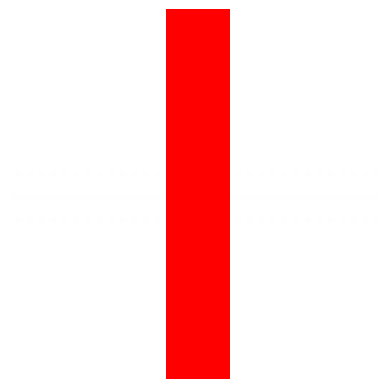

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math
KNOWN = 0
BAND = 1
INSIDE = 2
EPS = 1e-4

def solve(i1, j1, i2, j2,T,f):
    MAX_VALUE = 1000000
    sol = MAX_VALUE

    if i1 < 0 or i1 >= T.shape[0] or j1 < 0 or j1 >= T.shape[1]:
        return sol

    if i2 < 0 or i2 >= T.shape[0] or j2 < 0 or j2 >= T.shape[1]:
        return sol

    flag1 = f[i1, j1]
    flag2 = f[i2, j2]


    if flag1 == KNOWN and flag2 == KNOWN:
        T1 = T[i1, j1]
        T2 = T[i2, j2]
        d = 2.0 - (T1 - T2) ** 2
        if d > 0.0:
            r = math.sqrt(d)
            s = (T1 + T2 - r) / 2.0
            if s >= T1 and s >= T2:
                return s
            else:
                s += r
                if s <= T1 and s <= T2:
                    return s


    if flag1 == KNOWN:
        T1 = T[i1, j1]
        return 1.0 + T1
    elif flag2 == KNOWN:
        T2 = T[i2, j2]
        return 1.0 + T2


    return sol


def inpaint(i, j, T, image):
    b=10

    Be = [(i - b, j), (i + b, j), (i, j - b), (i, j + b)]
    grad_T = np.gradient(T)
    gradI = np.array([0, 0])


    for z in range(3):
        Ia = 0
        s = 0
        for x in Be:
            if 0 <= x[0] < image.shape[0] and 0 <= x[1] < image.shape[1] and f[x[0],x[1]]==KNOWN:
                r = np.array([x[0] - i, x[1] - j])
                dot_gradt_r = (grad_T[0][i, j] * r[0]) + (grad_T[1][i, j] * r[1])
                dir = dot_gradt_r / (np.linalg.norm(r, 1))
                if dir==0:
                  dir=EPS
                dst = 1 / (np.linalg.norm(r, 1) ** 2)
                lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
                w = abs(dir * dst * lev)

                if (0 <= x[0] + 1 < image.shape[0] and 0 <= x[1] + 1 < image.shape[1] and 0 <= x[0] - 1 and x[1] - 1 >= 0):
                    gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])
                dot_gradi_r = (gradI[0] * r[0]) + (gradI[1] * r[1])
                Ia += w * (image[x[0], x[1], z] + dot_gradi_r)
                s += w
        if s!=0:
                   image[i, j, z] = Ia / s
        else:
                  image[i,j,z]=0

    return image



image_width = 64
image_height = 64
image = np.ones((image_height, image_width, 3), dtype=np.uint8) * 255
start_point = (image_width // 2, 0)
end_point = (image_width // 2, image_height)
image = cv2.line(image, start_point, end_point, (255, 0, 0), 10)
start_point = (0, image_height // 2)
end_point = (image_width, image_height // 2)
image = cv2.line(image, start_point, end_point, (0, 0, 0), 10)

plt.imshow(image)
plt.axis('off')
plt.show()

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
T = np.zeros_like(gray_image)
narrow_band = []
f = np.zeros_like(gray_image)

for i in range(0, gray_image.shape[0]):
    for j in range(0, gray_image.shape[1]):
       if gray_image[i, j] != 0:
        T[i, j] = 0
        f[i,j] = KNOWN
        if gray_image[min(i+1,gray_image.shape[0]-1), j]== 0 or gray_image[max(i-1,0), j]== 0 or gray_image[i,min(j+1,gray_image.shape[0]-1)]==0 or gray_image[i ,max(j-1,0)]==0:
            f[i,j]=BAND
            narrow_band.append([i, j])
       else:
            T[i, j] =1000000
            f[i,j]=INSIDE

for iteration in range(1):

  while narrow_band:
      min_distance = 1000000
      min_point = None

      for point in narrow_band:
          if T[point[0], point[1]] < min_distance:
              min_distance = T[point[0], point[1]]
              min_point = point

      current_point = min_point

      if current_point is None:
          break
      f[current_point[0],current_point[1]]=KNOWN
      narrow_band.remove(current_point)

      neighbors = [(current_point[0] - 1, current_point[1]),(current_point[0] + 1, current_point[1]),(current_point[0], current_point[1] - 1),(current_point[0], current_point[1] + 1)]

      for neighbor in neighbors:
        if 0 <= neighbor[0] < image.shape[0] and 0 <= neighbor[1] < image.shape[1]:
          if f[neighbor[0],neighbor[1]]!=KNOWN:
            if f[neighbor[0],neighbor[1]]==INSIDE:
              f[neighbor[0],neighbor[1]]=BAND
              inpaint(neighbor[0],neighbor[1],T,image)
            T[neighbor[0],neighbor[1]]=min(solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]+1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]+1,T,f))
            narrow_band.append(neighbor)



plt.imshow(image)
plt.axis('off')
plt.show()




#revised code made exactly as instructed in the paper

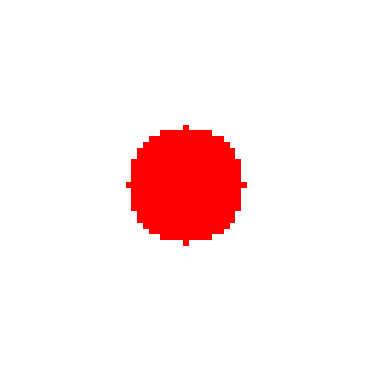

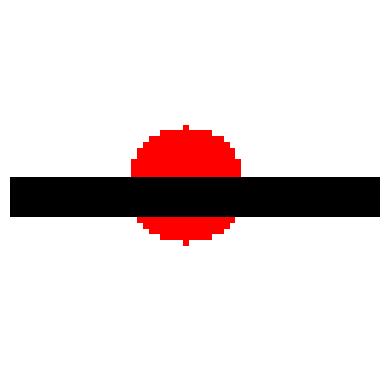

[[28, 0], [28, 1], [28, 2], [28, 3], [28, 4], [28, 5], [28, 6], [28, 7], [28, 8], [28, 9], [28, 10], [28, 11], [28, 12], [28, 13], [28, 14], [28, 15], [28, 16], [28, 17], [28, 18], [28, 19], [28, 20], [28, 21], [28, 22], [28, 23], [28, 24], [28, 25], [28, 26], [28, 27], [28, 28], [28, 29], [28, 30], [28, 31], [28, 32], [28, 33], [28, 34], [28, 35], [28, 36], [28, 37], [28, 38], [28, 39], [28, 40], [28, 41], [28, 42], [28, 43], [28, 44], [28, 45], [28, 46], [28, 47], [28, 48], [28, 49], [28, 50], [28, 51], [28, 52], [28, 53], [28, 54], [28, 55], [28, 56], [28, 57], [28, 58], [28, 59], [28, 60], [28, 61], [28, 62], [28, 63], [36, 0], [36, 1], [36, 2], [36, 3], [36, 4], [36, 5], [36, 6], [36, 7], [36, 8], [36, 9], [36, 10], [36, 11], [36, 12], [36, 13], [36, 14], [36, 15], [36, 16], [36, 17], [36, 18], [36, 19], [36, 20], [36, 21], [36, 22], [36, 23], [36, 24], [36, 25], [36, 26], [36, 27], [36, 28], [36, 29], [36, 30], [36, 31], [36, 32], [36, 33], [36, 34], [36, 35], [36, 36], [36, 37],

<ipython-input-1-3882602542ff>:79: RuntimeWarning: overflow encountered in ubyte_scalars
  lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
<ipython-input-1-3882602542ff>:83: RuntimeWarning: overflow encountered in ubyte_scalars
  gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])


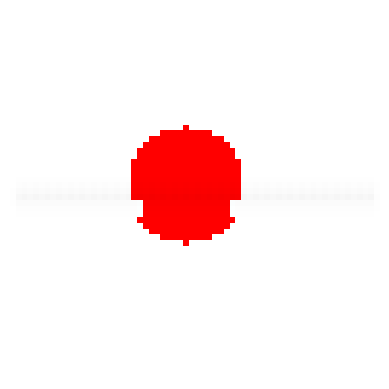

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math
KNOWN = 0
BAND = 1
INSIDE = 2
EPS = 1e-4







def solve(i1, j1, i2, j2,T,f):
    MAX_VALUE = 1000000
    sol = MAX_VALUE

    if i1 < 0 or i1 >= T.shape[0] or j1 < 0 or j1 >= T.shape[1]:
        return sol

    if i2 < 0 or i2 >= T.shape[0] or j2 < 0 or j2 >= T.shape[1]:
        return sol

    flag1 = f[i1, j1]
    flag2 = f[i2, j2]


    if flag1 == KNOWN and flag2 == KNOWN:
        T1 = T[i1, j1]
        T2 = T[i2, j2]
        d = 2.0 - (T1 - T2) ** 2
        if d > 0.0:
            r = math.sqrt(d)
            s = (T1 + T2 - r) / 2.0
            if s >= T1 and s >= T2:
                return s
            else:
                s += r
                if s <= T1 and s <= T2:
                    return s


    if flag1 == KNOWN:
        T1 = T[i1, j1]
        return 1.0 + T1
    elif flag2 == KNOWN:
        T2 = T[i2, j2]
        return 1.0 + T2


    return sol





def inpaint(i, j, T, image):
    b=1

    Be = [(i - b, j), (i + b, j), (i, j - b), (i, j + b)]
    grad_T = np.gradient(T)
    gradI = np.array([0, 0])


    for z in range(3):
        Ia = 0
        s = 0
        for x in Be:
            if 0 <= x[0] < image.shape[0] and 0 <= x[1] < image.shape[1] and f[x[0],x[1]]==KNOWN :
                r = np.array([x[0] - i, x[1] - j])
                dot_gradt_r = (grad_T[0][i, j] * r[0]) + (grad_T[1][i, j] * r[1])
                dir = dot_gradt_r / (np.linalg.norm(r, 1))
                if dir==0:
                  dir=EPS
                dst = 1 / (np.linalg.norm(r, 1) ** 2)
                lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
                w = abs(dir * dst * lev)

                if (0 <= x[0] + 1 < image.shape[0] and 0 <= x[1] + 1 < image.shape[1] and 0 <= x[0] - 1 and x[1] - 1 >= 0):
                    gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])
                dot_gradi_r = (gradI[0] * r[0]) + (gradI[1] * r[1])
                Ia += w * (image[x[0], x[1], z] + dot_gradi_r)
                s += w
        if s!=0:
          image[i, j, z] = Ia / s
        else:
          image[i, j, z] = 0
    return image



image_width = 64
image_height = 64
image = np.ones((image_height, image_width, 3), dtype=np.uint8) * 255
image = cv2.circle(image, (30,30),10, (255,0,0), -1)
plt.imshow(image)
plt.axis('off')
plt.show()
start_point = (0, image_height // 2)
end_point = (image_width, image_height // 2)
image = cv2.line(image, start_point, end_point, (0, 0, 0), 5)


plt.imshow(image)
plt.axis('off')
plt.show()

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
T = np.zeros_like(gray_image)
narrow_band = []
f = np.zeros_like(gray_image)

for i in range(0, gray_image.shape[0]):
    for j in range(0, gray_image.shape[1]):
       if gray_image[i, j] != 0:
        T[i, j] = 0
        f[i,j] = KNOWN
        if gray_image[min(i+1,gray_image.shape[0]-1), j]== 0 or gray_image[max(i-1,0), j]== 0 or gray_image[i,min(j+1,gray_image.shape[0]-1)]==0 or gray_image[i ,max(j-1,0)]==0:
            f[i,j]=BAND
            narrow_band.append([i, j])
       else:
            T[i, j] =1000000
            f[i,j]=INSIDE
print(narrow_band)
for iteration in range(10):

  while narrow_band:
      min_distance = 1000000
      min_point = None

      for point in narrow_band:
          if T[point[0], point[1]] < min_distance:
              min_distance = T[point[0], point[1]]
              min_point = point

      current_point = min_point

      if current_point is None:
          break
      f[current_point[0],current_point[1]]=KNOWN
      narrow_band.remove(current_point)

      neighbors = [(current_point[0] - 1, current_point[1]),(current_point[0] + 1, current_point[1]),(current_point[0], current_point[1] - 1),(current_point[0], current_point[1] + 1)]

      for neighbor in neighbors:
        if 0 <= neighbor[0] < image.shape[0] and 0 <= neighbor[1] < image.shape[1]:
          if f[neighbor[0],neighbor[1]]!=KNOWN:
            if f[neighbor[0],neighbor[1]]==INSIDE:
              f[neighbor[0],neighbor[1]]=BAND
              b=10
              inpaint(neighbor[0],neighbor[1],T,image)
            T[neighbor[0],neighbor[1]]=min(solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]+1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]+1,T,f))
            narrow_band.append(neighbor)



plt.imshow(image)
plt.axis('off')
plt.show()

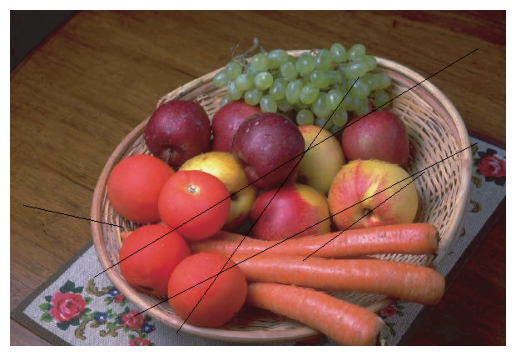

<ipython-input-32-1f9b3c2b70cf>:71: RuntimeWarning: overflow encountered in ubyte_scalars
  lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
<ipython-input-32-1f9b3c2b70cf>:75: RuntimeWarning: overflow encountered in ubyte_scalars
  gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])
<ipython-input-32-1f9b3c2b70cf>:29: RuntimeWarning: overflow encountered in ubyte_scalars
  d = 2.0 - (T1 - T2) ** 2


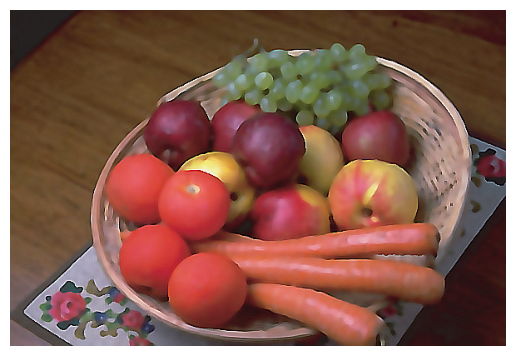

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math
import random
KNOWN = 0
BAND = 1
INSIDE = 2
EPS = 1e-6

def solve(i1, j1, i2, j2,T,f):
    MAX_VALUE = 1000000
    sol = MAX_VALUE

    if i1 < 0 or i1 >= T.shape[0] or j1 < 0 or j1 >= T.shape[1]:
        return sol

    if i2 < 0 or i2 >= T.shape[0] or j2 < 0 or j2 >= T.shape[1]:
        return sol

    flag1 = f[i1, j1]
    flag2 = f[i2, j2]


    if flag1 == KNOWN and flag2 == KNOWN:
        T1 = T[i1, j1]
        T2 = T[i2, j2]
        d = 2.0 - (T1 - T2) ** 2
        if d > 0.0:
            r = math.sqrt(d)
            s = (T1 + T2 - r) / 2.0
            if s >= T1 and s >= T2:
                return s
            else:
                s += r
                if s <= T1 and s <= T2:
                    return s


    if flag1 == KNOWN:
        T1 = T[i1, j1]
        return 1.0 + T1
    elif flag2 == KNOWN:
        T2 = T[i2, j2]
        return 1.0 + T2


    return sol


def inpaint(i, j, T, image):
    b=10

    Be = [(i - b, j), (i + b, j), (i, j - b), (i, j + b)]
    grad_T = np.gradient(T)
    gradI = np.array([0, 0])


    for z in range(3):
        Ia = 0
        s = 0
        for x in Be:
            if 0 <= x[0] < image.shape[0] and 0 <= x[1] < image.shape[1] and f[x[0],x[1]]==KNOWN:
                r = np.array([x[0] - i, x[1] - j])
                dot_gradt_r = (grad_T[0][i, j] * r[0]) + (grad_T[1][i, j] * r[1])
                dir = dot_gradt_r / (np.linalg.norm(r, 1))
                if dir==0:
                  dir=EPS
                dst = 1 / (np.linalg.norm(r, 1) ** 2)
                lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
                w = (dir * dst * lev)

                if (0 <= x[0] + 1 < image.shape[0] and 0 <= x[1] + 1 < image.shape[1] and 0 <= x[0] - 1 and x[1] - 1 >= 0):
                    gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])
                dot_gradi_r = (gradI[0] * r[0]) + (gradI[1] * r[1])
                Ia += w * (image[x[0], x[1], z] + dot_gradi_r)
                s += w
        if s!=0:
                   image[i, j, z] = Ia / s
        else:
                  image[i,j,z]=0

    return image




image_pic = cv2.imread('/content/sample11.png')
min_y, max_y = 0, image_pic.shape[0]
min_x, max_x = 0, image_pic.shape[1]
for  m in range(5):
  start_point = (random.randint(min_x, max_x), random.randint(min_y, max_y))
  end_point = (random.randint(min_x, max_x), random.randint(min_y, max_y))
  image_pic = cv2.line(image_pic, start_point, end_point,(0,0,0),1)

plt.imshow(cv2.cvtColor(image_pic, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

gray_image = cv2.cvtColor(image_pic, cv2.COLOR_BGR2GRAY)
T = np.zeros_like(gray_image)
narrow_band = []
f = np.zeros_like(gray_image)

for i in range(0, gray_image.shape[0]):
    for j in range(0, gray_image.shape[1]):
       if gray_image[i, j] != 0:
        T[i, j] = 0
        f[i,j] = KNOWN
        if gray_image[min(i+1,gray_image.shape[0]-1), j]== 0 or gray_image[max(i-1,0), j]== 0 or gray_image[i,min(j+1,gray_image.shape[0]-1)]==0 or gray_image[i ,max(j-1,0)]==0:
            f[i,j]=BAND
            narrow_band.append([i, j])
       else:
            T[i, j] =1000000
            f[i,j]=INSIDE


for iteration in range(1):
  while narrow_band :
      min_distance = 1000000
      min_point = None

      for point in narrow_band:
          if T[point[0], point[1]] < min_distance:
              min_distance = T[point[0], point[1]]
              min_point = point

      current_point = min_point

      if current_point is None:
          break
      f[current_point[0],current_point[1]]=KNOWN
      narrow_band.remove(current_point)

      neighbors = [(current_point[0] - 1, current_point[1]),(current_point[0] + 1, current_point[1]),(current_point[0], current_point[1] - 1),(current_point[0], current_point[1] + 1)]

      for neighbor in neighbors:
        if 0 <= neighbor[0] < image_pic.shape[0] and 0 <= neighbor[1] < image_pic.shape[1]:
          if f[neighbor[0],neighbor[1]]!=KNOWN:
            if f[neighbor[0],neighbor[1]]==INSIDE:
              f[neighbor[0],neighbor[1]]=BAND
              inpaint(neighbor[0],neighbor[1],T,image_pic)
            T[neighbor[0],neighbor[1]]=min(solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]+1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]+1,T,f))
            narrow_band.append(neighbor)


image_pic=cv2.medianBlur(image_pic, 5)
image_pic=cv2.bilateralFilter(image_pic, d=9, sigmaColor=75, sigmaSpace=75)
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
image_pic=cv2.filter2D(image_pic, -1, sharpening_kernel)
plt.imshow(cv2.cvtColor(image_pic, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


